#### library

In [1]:
import os
from typing import List, Dict
from tqdm import tqdm
import numpy as np

# visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# warning
import warnings
warnings.filterwarnings('ignore')

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import add_dummy_feature
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# statsmodel
import statsmodels.api as sm
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.multivariate.manova import MANOVA


# model
import lightgbm as lgb
import optuna
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.optim as optim


print(torch.__version__)

2.4.1+cu121


#### data load

In [2]:
# 파일 호출
data_path: str = "../../../data"
train_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "train.csv")).assign(_type="train") # train 에는 _type = train 
test_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")).assign(_type="test") # test 에는 _type = test
submission_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")) # ID, target 열만 가진 데이터 미리 호출
df: pd.DataFrame = pd.concat([train_df, test_df], axis=0)

In [3]:
# HOURLY_ 로 시작하는 .csv 파일 이름을 file_names 에 할딩
file_names: List[str] = [
    f for f in os.listdir(data_path) if f.startswith("HOURLY_") and f.endswith(".csv")
]

# 파일명 : 데이터프레임으로 딕셔너리 형태로 저장
file_dict: Dict[str, pd.DataFrame] = {
    f.replace(".csv", ""): pd.read_csv(os.path.join(data_path, f)) for f in file_names
}

for _file_name, _df in tqdm(file_dict.items()):
    # 열 이름 중복 방지를 위해 {_file_name.lower()}_{col.lower()}로 변경, datetime 열을 ID로 변경
    _rename_rule = {
        col: f"{_file_name.lower()}_{col.lower()}" if col != "datetime" else "ID"
        for col in _df.columns
    }
    _df = _df.rename(_rename_rule, axis=1)
    df = df.merge(_df, on="ID", how="left")

100%|██████████| 107/107 [00:03<00:00, 30.08it/s]


#### data engineering

In [4]:
# missing value check

train_df = df.loc[df["_type"] == "train"]
# 각 열에서 누락된 값의 수 & 백분율 계산
missing_values = train_df.isnull().sum()
missing_percentage = (missing_values / len(train_df)) * 100

# 누락된 값 비율을 기준으로 열 정렬
sorted_missing_percentage = missing_percentage.sort_values(ascending=False)

# missing_value의 비율이 100%가 아닌 column만 추출
non_missing_columns = sorted_missing_percentage[sorted_missing_percentage != 100.0].index.tolist()
non_missing_columns.remove('ID')
non_missing_columns.remove('target')
non_missing_columns.remove('_type')

new_data = train_df[['ID','target', '_type'] + non_missing_columns]

In [5]:
# 이동평균으로 결측치 대체
new_df_stab = new_data[non_missing_columns]

# train
window_size = 3
new_df_stab = new_df_stab.apply(lambda col: col.fillna(col.rolling(window=window_size, min_periods=1).mean()))
new_df_stab = new_df_stab.fillna(method='ffill').fillna(method='bfill')


# 결측치 처리한 new_df 정의
new_train_df = pd.concat([new_data[['ID','target','_type']], new_df_stab], axis=1)

In [6]:
# nan or inf 데이터 여부 확인
for col in non_missing_columns:
    if (np.isnan(new_train_df[col]).any()) | (np.isinf(new_train_df[col]).any()):
        print(col)
        break

In [7]:

test_df = df.loc[df["_type"] == "test"]
new_test_df = test_df[['ID','target','_type'] + non_missing_columns]

new_test_stab = new_test_df[non_missing_columns]
# test
window_size = 3
new_test_stab = new_test_stab.apply(lambda col: col.fillna(col.rolling(window=window_size, min_periods=1).mean()))
new_test_stab = new_test_stab.fillna(method='ffill').fillna(method='bfill')

new_test_df = pd.concat([new_test_df[['ID','target','_type']], new_test_stab], axis=1)

In [8]:
# 결측치 비율을 계산
missing_percentage = new_test_df.isnull().mean() * 100

# 결측치 비율이 100%인 컬럼 이름만 출력
columns_with_all_missing = missing_percentage[missing_percentage >= 50].index.tolist()

# 100% 결측치가 있는 컬럼 출력
columns_with_all_missing = [col for col in columns_with_all_missing if col not in ['target', 'hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close']]
columns_with_all_missing

['hourly_market-data_open-interest_binance_btc_busd_open_interest',
 'hourly_market-data_liquidations_binance_btc_busd_short_liquidations_usd',
 'hourly_market-data_liquidations_binance_btc_busd_long_liquidations',
 'hourly_market-data_liquidations_binance_btc_busd_short_liquidations',
 'hourly_market-data_liquidations_binance_btc_busd_long_liquidations_usd',
 'hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_volume']

In [9]:
# train_df와 test_df에서 columns_with_all_missing에 있는 컬럼 삭제
new_train_df = new_train_df.drop(columns=columns_with_all_missing, errors='ignore')
new_test_df = new_test_df.drop(columns=columns_with_all_missing, errors='ignore')

In [10]:
# 이동평균을 기반으로 이상치를 처리하는 함수
def replace_outlier(df, window=3, threshold=2):
    df_cleaned = df.copy()
    
    # 숫자형 컬럼들에 대해 처리
    for column in df_cleaned.select_dtypes(include=[np.number]).columns:
        # 이동평균과 표준편차 계산
        rolling_mean = df_cleaned[column].rolling(window=window, min_periods=1).mean()
        rolling_std = df_cleaned[column].rolling(window=window, min_periods=1).std()

        # 이상치 기준 설정
        outliers = np.abs(df_cleaned[column] - rolling_mean) > (threshold * rolling_std)

        # 이상치를 이동평균으로 대체
        df_cleaned.loc[outliers, column] = rolling_mean[outliers]
    
    return df_cleaned

# 이동평균 기반 이상치 처리 적용
cleaned_train_df = replace_outlier(new_train_df)
cleaned_test_df = replace_outlier(new_test_df)

In [11]:
# Standardization으로 정규화
from sklearn.preprocessing import StandardScaler

def standardization(train_df, test_df):
    features_to_scale = [col for col in train_df.columns if col not in ['ID', 'target', '_type']]

    scaler = StandardScaler()

    # 훈련 데이터 정규화
    train_df_scaled = train_df.copy()
    train_df_scaled[features_to_scale] = scaler.fit_transform(train_df[features_to_scale])

    # 테스트 데이터 정규화
    test_df_scaled = test_df.copy()
    test_df_scaled[features_to_scale] = scaler.transform(test_df[features_to_scale])

    return train_df_scaled, test_df_scaled

# 함수 호출
std_train_df, std_test_df = standardization(cleaned_train_df, cleaned_test_df)

#### price(종가) 예측

In [12]:
# 타겟과 피처 설정
price_data = std_train_df['hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close']
price_data.head(3)

0   -2.083215
1   -2.079750
2   -2.081277
Name: hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close, dtype: float64

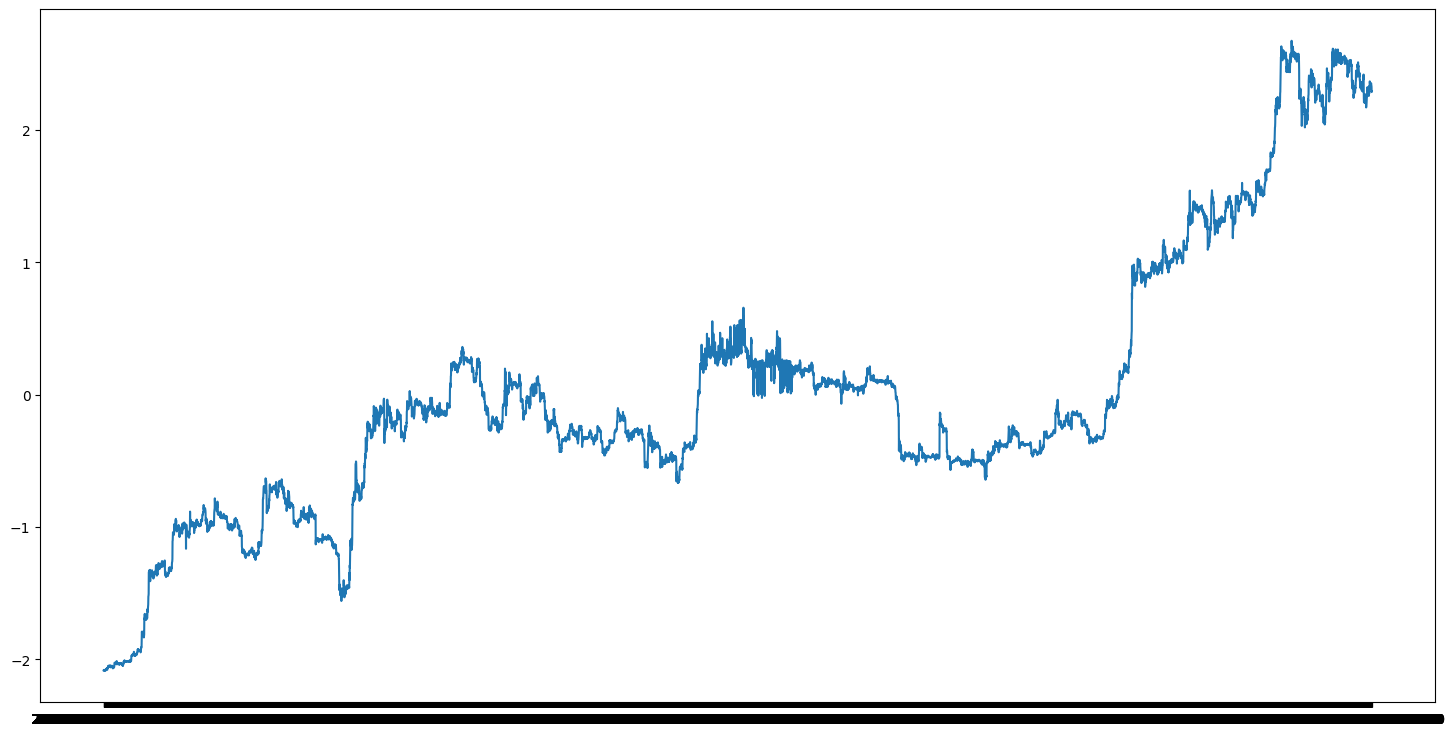

In [13]:
plt.figure(figsize=(18,9))
plt.plot(std_train_df['ID'], std_train_df['hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close'], linestyle="-")
plt.xlabel=('Day')
plt.ylabel=('Price')
plt.show()

In [14]:
def adf_test(timeseries, pvalue = .05, regression_option = 'ct'):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', regression = regression_option)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dfoutput[1] < pvalue:
        print(f"정상시계열이 아니라는 귀무가설을 {pvalue*100}%의 유의수준으로 기각할 수 있으므로 해당 데이터는 정상성이 보장됩니다.")
    else:
        print(f"정상시계열이 아니라는 귀무가설을 {pvalue*100}%의 유의수준으로 기각할 수 없으므로 해당 데이터는 정상성을 보장하지 못합니다.")

# adf 함수를 통해 출력
adf_test(price_data)

Results of Dickey-Fuller Test:
Test Statistic                   -1.723646
p-value                           0.740361
Lags Used                        37.000000
Number of Observations Used    8722.000000
Critical Value (1%)              -3.959808
Critical Value (5%)              -3.410993
Critical Value (10%)             -3.127346
dtype: float64
정상시계열이 아니라는 귀무가설을 5.0%의 유의수준으로 기각할 수 없으므로 해당 데이터는 정상성을 보장하지 못합니다.


In [15]:
def kpss_test(timeseries, pvalue = .05, regression_option = 'ct'):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression= regression_option)
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
    if kpss_output[1] < pvalue:
        print(f"정상시계열이 맞다는 귀무가설을 {pvalue*100}%의 유의수준으로 기각할 수 있으므로 해당 데이터는 정상성을 보장하지 못합니다.")
    else:
        print(f"정상시계열이 맞다는 귀무가설을 {pvalue*100}%의 유의수준으로 기각할 수 없으므로 해당 데이터는 정상성이 보장됩니다.")
        
kpss_test(price_data)

Results of KPSS Test:
Test Statistic            1.506183
p-value                   0.010000
Lags Used                56.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64
정상시계열이 맞다는 귀무가설을 5.0%의 유의수준으로 기각할 수 있으므로 해당 데이터는 정상성을 보장하지 못합니다.


/tmp/ipykernel_756147/4086091165.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries, regression= regression_option)


In [17]:
model_arima= auto_arima(price_data,trace=True, error_action='ignore', start_p=1,start_q=1,max_p=3,max_q=3,suppress_warnings=True,stepwise=False,seasonal=False)
model_arima.fit(price_data)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-35596.013, Time=0.45 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-36281.014, Time=1.25 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-36315.404, Time=2.43 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-36333.813, Time=0.63 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-36329.520, Time=0.33 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-36327.623, Time=2.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-36328.497, Time=2.00 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-36330.395, Time=1.47 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-36327.610, Time=0.62 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-36325.519, Time=2.50 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-36334.898, Time=5.47 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-36331.117, Time=4.62 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-36329.078, Time=0.49 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-36328.030, Time=1.73 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-36325

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True)

In [33]:
log_df = np.log(price_data+3) # 로그 변환(-2 값부터 있었기 때문에 3을 더해줬음. 추후에 예측된 값에서 np.exp와 -3을 실시해야할 것)
log_price_df = log_df.diff(1).dropna() # 1차 차분

In [19]:
print("ACF 값 : {0}".format(sm.tsa.stattools.acf(log_price_df, nlags=10, fft=False)))
print("PACF 값 : {0}".format(sm.tsa.stattools.pacf(log_price_df, nlags=10, method='ywm')))

ACF 값 : [ 1.         -0.45593986  0.10132529 -0.06756983  0.06614346 -0.12930231
  0.0430195   0.01446246 -0.02536225 -0.00977533  0.04749095]
PACF 값 : [ 1.         -0.45593986 -0.13452006 -0.09834346  0.00550924 -0.12272326
 -0.09272904 -0.01321    -0.03724294 -0.04568341  0.01230021]


In [35]:
model_arima= auto_arima(log_df,trace=True, error_action='ignore',d = 1, start_p=1,start_q=1,max_p=3,max_q=3,suppress_warnings=True,stepwise=False,seasonal=False)
model_arima.fit(log_df)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-54689.509, Time=0.46 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-55191.496, Time=0.42 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-55224.454, Time=0.85 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-55228.753, Time=1.86 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-55231.113, Time=0.46 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-55230.308, Time=1.23 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-55229.386, Time=0.93 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-55227.078, Time=1.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-55230.229, Time=1.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-55231.478, Time=1.32 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-55224.959, Time=3.77 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-55225.360, Time=2.01 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-55228.928, Time=1.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-55226.957, Time=1.84 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-55224

ARIMA(order=(2, 1, 1), scoring_args={}, suppress_warnings=True)

In [36]:
print(model_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 8760
Model:               SARIMAX(2, 1, 1)   Log Likelihood               27620.739
Date:                Wed, 25 Sep 2024   AIC                         -55231.478
Time:                        19:49:13   BIC                         -55196.088
Sample:                             0   HQIC                        -55219.419
                               - 8760                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0004      0.000      2.187      0.029    4.45e-05       0.001
ar.L1         -0.9958      0.131     -7.580      0.000      -1.253      -0.738
ar.L2         -0.1732      0.035     -4.956      0.0

In [37]:
model = sm.tsa.arima.ARIMA(log_df, order = (2,1,1))
model_fit = model.fit()
forecast = model_fit.predict()

In [40]:
price_pred = np.exp(forecast)-3
price_pred.shape

(8760,)

In [41]:
# new_test_df에 y_pred 값을 추가
std_test_df['hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close'] = price_pred

# 결과 확인
std_test_df.head(3)

,ID,target,_type,hourly_market-data_funding-rates_bybit_funding_rates,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_volume,hourly_market-data_taker-buy-sell-stats_bybit_taker_sell_volume,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_ratio,hourly_market-data_taker-buy-sell-stats_bybit_taker_sell_ratio,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_sell_ratio,hourly_network-data_fees-transaction_fees_transaction_mean,...,hourly_market-data_liquidations_binance_all_symbol_long_liquidations_usd,hourly_market-data_liquidations_binance_all_symbol_short_liquidations_usd,hourly_market-data_open-interest_htx_global_btc_usd_open_interest,hourly_network-data_addresses-count_addresses_count_receiver,hourly_network-data_fees_fees_total,hourly_network-data_fees_fees_total_usd,hourly_market-data_liquidations_htx_global_all_symbol_long_liquidations,hourly_market-data_liquidations_htx_global_all_symbol_short_liquidations,hourly_market-data_liquidations_htx_global_all_symbol_long_liquidations_usd,hourly_market-data_liquidations_htx_global_all_symbol_short_liquidations_usd
8760,2024-01-01 00:00:00,NaN,test,0.862267,0.047456,-0.368791,1.123435,-1.106685,0.628514,3.492500,...,-0.281419,0.622390,3.599144,-1.275562,1.945012,2.242378,-0.289134,-0.228944,-0.293700,-0.223232
8761,2024-01-01 01:00:00,NaN,test,1.129189,0.106802,-0.359145,1.203588,-1.186934,0.709193,1.236332,...,-0.281769,1.514263,3.687307,-0.856214,4.171627,4.675388,-0.285791,-0.137437,-0.288604,-0.090258
8762,2024-01-01 02:00:00,NaN,test,1.435859,-0.671125,-0.671636,-0.004335,0.022434,-0.173300,0.990473,...,-0.100861,-0.200075,3.704422,-0.958328,2.247406,2.580664,0.231648,-0.235255,0.500278,-0.232367


In [42]:
df = pd.concat([std_train_df, std_test_df], ignore_index=True)
df.head(3)

,ID,target,_type,hourly_market-data_funding-rates_bybit_funding_rates,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_volume,hourly_market-data_taker-buy-sell-stats_bybit_taker_sell_volume,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_ratio,hourly_market-data_taker-buy-sell-stats_bybit_taker_sell_ratio,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_sell_ratio,hourly_network-data_fees-transaction_fees_transaction_mean,...,hourly_market-data_liquidations_binance_all_symbol_long_liquidations_usd,hourly_market-data_liquidations_binance_all_symbol_short_liquidations_usd,hourly_market-data_open-interest_htx_global_btc_usd_open_interest,hourly_network-data_addresses-count_addresses_count_receiver,hourly_network-data_fees_fees_total,hourly_network-data_fees_fees_total_usd,hourly_market-data_liquidations_htx_global_all_symbol_long_liquidations,hourly_market-data_liquidations_htx_global_all_symbol_short_liquidations,hourly_market-data_liquidations_htx_global_all_symbol_long_liquidations_usd,hourly_market-data_liquidations_htx_global_all_symbol_short_liquidations_usd
0,2023-01-01 00:00:00,2.0,train,0.242277,-0.739005,-0.790786,0.677313,-0.660030,0.248331,-0.452496,...,-0.327741,-0.346728,-0.099874,0.946969,-0.472265,-0.467622,-0.289134,-0.23536,-0.2937,-0.232519
1,2023-01-01 01:00:00,1.0,train,0.242277,-0.555248,-0.812900,2.230195,-2.214769,2.351257,-0.476448,...,-0.328215,-0.319897,0.005954,-0.773384,-0.540988,-0.496686,-0.289134,-0.23536,-0.2937,-0.232519
2,2023-01-01 02:00:00,1.0,train,0.242277,-0.844533,-0.783052,-1.185413,1.204924,-0.646820,-0.417162,...,-0.328215,-0.346728,-0.005201,-0.889786,-0.528197,-0.491262,-0.289134,-0.23536,-0.2937,-0.232519


#### feature engineering

In [43]:
# 모델에 사용할 컬럼, 컬럼의 rename rule을 미리 할당함
cols_dict: Dict[str, str] = {
    "ID": "ID",
    "target": "target",
    "_type": "_type",
    "hourly_market-data_coinbase-premium-index_coinbase_premium_gap": "coinbase_premium_gap",
    "hourly_market-data_coinbase-premium-index_coinbase_premium_index": "coinbase_premium_index",
    "hourly_market-data_funding-rates_all_exchange_funding_rates": "funding_rates",
    "hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations": "long_liquidations",
    "hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations_usd": "long_liquidations_usd",
    "hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations": "short_liquidations",
    "hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations_usd": "short_liquidations_usd",
    "hourly_market-data_open-interest_all_exchange_all_symbol_open_interest": "open_interest",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_ratio": "buy_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_sell_ratio": "buy_sell_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_volume": "buy_volume",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_ratio": "sell_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_volume": "sell_volume",
    "hourly_network-data_addresses-count_addresses_count_active": "active_count",
    "hourly_network-data_addresses-count_addresses_count_receiver": "receiver_count",
    "hourly_network-data_addresses-count_addresses_count_sender": "sender_count",
    "hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close" : "close",
}
df = df[cols_dict.keys()].rename(cols_dict, axis=1)
df.shape

(11552, 20)

In [44]:
# eda 에서 파악한 차이와 차이의 음수, 양수 여부를 새로운 피쳐로 생성
df = df.assign(
    liquidation_diff=df["long_liquidations"] - df["short_liquidations"],
    liquidation_usd_diff=df["long_liquidations_usd"] - df["short_liquidations_usd"],
    volume_diff=df["buy_volume"] - df["sell_volume"],
    liquidation_diffg=np.sign(df["long_liquidations"] - df["short_liquidations"]),
    liquidation_usd_diffg=np.sign(df["long_liquidations_usd"] - df["short_liquidations_usd"]),
    volume_diffg=np.sign(df["buy_volume"] - df["sell_volume"]),
    buy_sell_volume_ratio=df["buy_volume"] / (df["sell_volume"] + 1),
    close_diff = df['close'].diff().fillna(0),
    close_diffg = np.sign(df['close'].diff().fillna(0))
)
# category, continuous 열을 따로 할당해둠
category_cols: List[str] = ["liquidation_diffg", "liquidation_usd_diffg", "volume_diffg", "close_diffg"]
conti_cols: List[str] = [_ for _ in cols_dict.values() if _ not in ["ID", "target", "_type"]] + [
    "buy_sell_volume_ratio",
    "liquidation_diff",
    "liquidation_usd_diff",
    "volume_diff",
    "close_diff"
]

In [45]:
def shift_feature(
    df: pd.DataFrame,
    conti_cols: List[str],
    intervals: List[int],
) -> List[pd.Series]:
    """
    연속형 변수의 shift feature 생성
    Args:
        df (pd.DataFrame)
        conti_cols (List[str]): continuous colnames
        intervals (List[int]): shifted intervals
    Return:
        List[pd.Series]
    """
    df_shift_dict = [
        df[conti_col].shift(interval).rename(f"{conti_col}_{interval}")
        for conti_col in conti_cols
        for interval in intervals
    ]
    return df_shift_dict

# 최대 24시간의 shift 피쳐를 계산
shift_list = shift_feature(
    df=df, conti_cols=conti_cols, intervals=[_ for _ in range(1, 24)]
)

In [46]:
# concat 하여 df 에 할당
df = pd.concat([df, pd.concat(shift_list, axis=1)], axis=1)

# 타겟 변수를 제외한 변수를 forwardfill, -999로 결측치 대체
_target = df["target"]
df = df.ffill().fillna(-999).assign(target = _target)

# _type에 따라 train, test 분리
train_df = df.loc[df["_type"]=="train"].drop(columns=["_type"])
test_df = df.loc[df["_type"]=="test"].drop(columns=["_type"])

#### model training

In [47]:
# train_test_split 으로 valid set, train set 분리
x_train, x_valid, y_train, y_valid = train_test_split(
    train_df.drop(["target", "ID"], axis = 1), 
    train_df["target"].astype(int), 
    test_size=0.2,
    random_state=42,
)

# lgb dataset
train_data = lgb.Dataset(x_train, label=y_train)
valid_data = lgb.Dataset(x_valid, label=y_valid, reference=train_data)

# lgb params
params = {
    "boosting_type": "gbdt",
    "objective": "multiclass",
    "metric": "multi_logloss",
    "num_class": 4,
    "num_leaves": 50,
    "learning_rate": 0.05,
    "n_estimators": 30,
    "random_state": 42,
    "verbose": 0,
}

# lgb train
lgb_model = lgb.train(
    params=params,
    train_set=train_data,
    valid_sets=valid_data,
)

# lgb predict
y_valid_pred = lgb_model.predict(x_valid)
y_valid_pred_class = np.argmax(y_valid_pred, axis = 1)

# score check
accuracy = accuracy_score(y_valid, y_valid_pred_class)
auroc = roc_auc_score(y_valid, y_valid_pred, multi_class="ovr")

print(f"acc: {accuracy}, auroc: {auroc}")

acc: 0.442351598173516, auroc: 0.6484788380773734


In [48]:
# performance 체크후 전체 학습 데이터로 다시 재학습
x_train = train_df.drop(["target", "ID"], axis = 1)
y_train = train_df["target"].astype(int)
train_data = lgb.Dataset(x_train, label=y_train)
lgb_model = lgb.train(
    params=params,
    train_set=train_data,
)

In [49]:
# lgb predict
y_test_pred = lgb_model.predict(test_df.drop(["target", "ID"], axis = 1))
y_test_pred_class = np.argmax(y_test_pred, axis = 1)

In [51]:
a = pd.read_csv("output/output_high.csv")
b = list(a['target'])
count = 0
for i,j in zip(y_test_pred_class, b):
    if i == j:
        count += 1
count

2187

In [52]:
# output file 할당후 save 
submission_df = submission_df.assign(target = y_test_pred_class)
submission_df.to_csv("output_arima.csv", index=False)